### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import itertools
import glob
from tqdm.notebook import tqdm
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch.autograd import Variable
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch

## Setting the variables

In [2]:
epoch = 0 # epochs to start training from
n_epochs = 200 # number of epochs of training
batch_size = 16 # size of the batches. suggested 16
lr = 0.0002 # learning rate
b1 = 0.5 # decay of first order momentum of gradient
b2 = 0.999 # decay of first order momentum of gradient
decay_epoch = 100 # epoch from which to start lr decay

In [4]:
#This is the path of the images in the celebA dataset
root = 'dataset/img_align_celeba/img_align_celeba/'
#Making image size 128x128
img_height = 128 # size of image height
img_width = 128 # size of image width
channels = 3 # number of image channels
residual_blocks = 6 # number of residual blocks in generator
n_critic = 5 # number of training iterations for WGAN discriminator
# Here, I selected 18 attributes for the CelebA dataset, this can be changed.
selected_attrs = ['5_o_Clock_Shadow','Arched_Eyebrows','Attractive','Bags_Under_Eyes','Bald','Bangs','Big_Lips','Big_Nose','Black_Hair','Blond_Hair','Blurry',
 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby','Double_Chin','Eyeglasses','Male','Young'] 

In [5]:
c_dim = len(selected_attrs) # number of input-attributes
c_dim

18

In [13]:
img_shape = (channels, img_height, img_width) # image shape for pytorch
img_shape

(3, 128, 128)

### Generator Architecture

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        conv_block = [
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(in_features, affine=True, track_running_stats=True)
        ]
        
        self.conv_block = nn.Sequential(*conv_block) # list-unpacking
    
    def forward(self, x):
        return x + self.conv_block(x)

In [18]:
class GeneratorResNet(nn.Module):
    def __init__(self, img_shape=(3,128,128), res_blocks=9, c_dim=5):
        super(GeneratorResNet, self).__init__()
        channels, img_size, _ = img_shape
        
        # Initial convolution block
        model = [
            nn.Conv2d(channels+c_dim, 64, 7, stride=1, padding=3, bias=False), # in_channels = channels+c_dim (domain added in channel)
            nn.InstanceNorm2d(64, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        ]
        
        # Downsampling
        curr_dim = 64
        for _ in range(2):
            model += [
                nn.Conv2d(curr_dim, curr_dim*2, 4, stride=2, padding=1, bias=False), 
                nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True)
            ]
            curr_dim *= 2 # 64->128
        
        # Residual blocks
        for _ in range(res_blocks): # 9-loop
            model += [ResidualBlock(curr_dim)] # 128->128
        
        # Upsampling
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(curr_dim, curr_dim//2, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True),
                nn.ReLU(inplace=True),
            ]
            curr_dim = curr_dim//2 # 128->64
            
        # Output layer
        model += [
            nn.Conv2d(curr_dim, channels, 7, stride=1, padding=3), # 64 -> 3 (return RGB Image)
            nn.Tanh() # -1 < tanh(x) < 1
        ]
        
        self.model = nn.Sequential(*model) # Unpack the list of layers 
    
    def forward(self, x, c):
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat((x,c), 1) # get image(x) and domain(c) 
        return self.model(x)

### Discriminator Architecture

In [19]:
class Discriminator(nn.Module):
    def __init__(self, img_shape=(3,128,128), c_dim=5, n_strided=6):
        super(Discriminator, self).__init__()
        channels, img_size, _ = img_shape
        
        def discriminator_block(in_filters, out_filters):
            """Returns downsampling layers of each discriminator block"""
            layers = [
                nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1), 
                nn.LeakyReLU(0.01)
            ]
            return layers
        
        layers = discriminator_block(channels, 64)
        curr_dim = 64
        for _ in range(n_strided-1):
            layers.extend(discriminator_block(curr_dim, curr_dim*2))
            curr_dim *= 2
            
        self.model = nn.Sequential(*layers)
        
        # Output 1 : PatchGAN
        self.out1 = nn.Conv2d(curr_dim, 1, 3, padding=1, bias=False)
        # Output 2 : Class prediction
        kernel_size = img_size//(2**n_strided)
        self.out2 = nn.Conv2d(curr_dim, c_dim, kernel_size, bias=False)
        
    def forward(self, img):
        feature_repr = self.model(img)
        out_adv = self.out1(feature_repr) # real or fake
        out_cls = self.out2(feature_repr) # matching-domain
        return out_adv, out_cls.view(out_cls.size(0), -1)
        

### Defining Loss function and Initializing Loss weights

In [20]:
# Loss function - Cycle loss
criterion_cycle = torch.nn.L1Loss()

In [21]:
# Loss function - Domain-Class loss
def criterion_cls(logit, target):
    return F.binary_cross_entropy_with_logits(logit, target, size_average=False) / logit.size(0)

In [22]:
# Loss weights
lambda_cls = 1
lambda_rec = 10
lambda_gp = 10

### Initializing Generator and Discriminator

In [23]:
generator = GeneratorResNet(img_shape=img_shape, res_blocks=residual_blocks, c_dim=c_dim)
discriminator = Discriminator(img_shape=img_shape, c_dim=c_dim)

### Weight Setting

In [24]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution

In [25]:
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal);

### Configuring Optimizers

In [26]:
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr,
    betas=(b1,b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(),
    lr=lr,
    betas=(b1,b2)
)

### Defining CelebA dataset class for handling labeled dataset

Here I have chosen only 12000 images from the CelebA dataset, you can change them as needed

In [6]:
class CelebADataset(Dataset):
    def __init__(self, root, transforms_=None, mode='train', attributes=None):
        self.transform = transforms.Compose(transforms_)
        
        self.selected_attrs = attributes
        self.files = sorted(glob.glob('%s/*.jpg' %root))
        if mode == 'train':
            self.files = self.files[:1000] # 1,000
        elif mode == 'test':
            self.files = self.files[1000:1200] # 200
        self.annotations = self.get_annotations()
        
    def get_annotations(self):
        """Extracts annotations for CelebA"""
        label_df = pd.read_csv('dataset/list_attr_celeba.csv')
        label_df = label_df[:12000]
        label_names = list(label_df.columns)[1:]
        annotations = {}
        for _, row in label_df.iterrows():
            filename = row.values[0]
            values = row[1:]
            labels = []
            for attr in selected_attrs: # selected_attr = ["Black_Hair", "Blond_Hair", "Brown_Hair", "Male", "Young"]
                idx = label_names.index(attr) # get index of selected 'attr'
                labels.append(1 * (values[idx]==1))
            annotations[filename] = labels
        return annotations
    
    def __getitem__(self, index):
        filepath = self.files[index % len(self.files)]
        filename = filepath.split('/')[-1]
        img = self.transform(Image.open(filepath))
        label = self.annotations[filename]
        label = torch.FloatTensor(np.array(label))
        return img, label
    
    def __len__(self):
        return len(self.files)

In [7]:
label_df = pd.read_csv('dataset/list_attr_celeba.csv')

In [8]:
label_df.head()

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
0  000001.jpg                -1                1           1               -1   
1  000002.jpg                -1               -1          -1                1   
2  000003.jpg                -1               -1          -1               -1   
3  000004.jpg                -1               -1           1               -1   
4  000005.jpg                -1                1           1               -1   

   Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  Sideburns  Smiling  \
0    -1     -1        -1        -1          -1  ...         -1        1   
1    -1     -1        -1         1          -1  ...         -1        1   
2    -1     -1         1        -1          -1  ...         -1       -1   
3    -1     -1        -1        -1          -1  ...         -1       -1   
4    -1     -1         1        -1          -1  ...         -1       -1   

   Straight_Hair  Wavy_Hair  Wearing_Earrings  Wearing_Hat  Wearing_Lipstick  \
0              1         -1                 1           -1                 1   
1             -1         -1                -1           -1                -1   
2             -1          1                -1           -1                -1   
3              1         -1                 1           -1                 1   
4             -1         -1                -1           -1                 1   

   Wearing_Necklace  Wearing_Necktie  Young  
0                -1               -1      1  
1                -1               -1      1  
2                -1               -1      1  
3                 1               -1      1  
4                -1               -1      1  

[5 rows x 41 columns]

In [31]:
label_df = label_df[:12000]
label_df

image_id  5_o_Clock_Shadow  Arched_Eyebrows  Attractive  \
0      000001.jpg                -1                1           1   
1      000002.jpg                -1               -1          -1   
2      000003.jpg                -1               -1          -1   
3      000004.jpg                -1               -1           1   
4      000005.jpg                -1                1           1   
...           ...               ...              ...         ...   
11995  011996.jpg                -1               -1          -1   
11996  011997.jpg                -1               -1           1   
11997  011998.jpg                -1                1           1   
11998  011999.jpg                -1                1           1   
11999  012000.jpg                -1               -1          -1   

       Bags_Under_Eyes  Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  ...  \
0                   -1    -1     -1        -1        -1          -1  ...   
1                    1    -1     -1        -1         1          -1  ...   
2                   -1    -1     -1         1        -1          -1  ...   
3                   -1    -1     -1        -1        -1          -1  ...   
4                   -1    -1     -1         1        -1          -1  ...   
...                ...   ...    ...       ...       ...         ...  ...   
11995                1    -1      1        -1        -1          -1  ...   
11996               -1    -1     -1         1        -1          -1  ...   
11997               -1    -1     -1         1        -1          -1  ...   
11998               -1    -1     -1        -1        -1           1  ...   
11999                1     1     -1        -1        -1          -1  ...   

       Sideburns  Smiling  Straight_Hair  Wavy_Hair  Wearing_Earrings  \
0             -1        1              1         -1                 1   
1             -1        1             -1         -1                -1   
2             -1       -1             -1          1                -1   
3             -1       -1              1         -1                 1   
4             -1       -1             -1         -1                -1   
...          ...      ...            ...        ...               ...   
11995         -1       -1             -1         -1                 1   
11996         -1       -1             -1          1                -1   
11997         -1       -1             -1         -1                -1   
11998         -1        1             -1         -1                 1   
11999         -1       -1             -1         -1                -1   

       Wearing_Hat  Wearing_Lipstick  Wearing_Necklace  Wearing_Necktie  Young  
0               -1                 1                -1               -1      1  
1               -1                -1                -1               -1      1  
2               -1                -1                -1               -1      1  
3               -1                 1                 1               -1      1  
4               -1                 1                -1               -1      1  
...            ...               ...               ...              ...    ...  
11995           -1                 1                 1               -1     -1  
11996           -1                 1                -1               -1      1  
11997           -1                 1                -1               -1      1  
11998           -1                 1                -1               -1      1  
11999           -1                -1                -1                1     -1  

[12000 rows x 41 columns]

In [32]:
label_names = list(label_df.columns)[1:]
label_names

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [33]:
print(*list(label_df.iloc[0]))

000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 1 1 -1 1 -1 -1 1 -1 -1 1 -1 -1 -1 1 1 -1 1 -1 1 -1 -1 1


In [34]:
label_df.iloc[0][0]

'000001.jpg'

In [35]:
print(*list(label_df.iloc[0][1:]))

-1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 1 1 -1 1 -1 -1 1 -1 -1 1 -1 -1 -1 1 1 -1 1 -1 1 -1 -1 1


In [36]:
for _, row in label_df.iterrows():
    print('filename :\n\t',row.values[0])
    print('one-hot-label :\n\t',row.values[1:])
    break

filename :
	 000001.jpg
one-hot-label :
	 [-1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1 -1 -1 -1 -1 -1 -1 1 1 -1 1 -1 -1 1 -1 -1
 1 -1 -1 -1 1 1 -1 1 -1 1 -1 -1 1]


In [39]:
annotations = {}
for _, row in tqdm(label_df.iterrows(), total=len(label_df)):
    filename = row.values[0]
    values = row[1:]
    labels = []
    for attr in selected_attrs: # selected_attributes
        idx = label_names.index(attr) # get index of selected 'attr'
        labels.append(1 * (values[idx]==1))
    annotations[filename] = labels

  0%|          | 0/12000 [00:00<?, ?it/s]

In [40]:
for i in range(1,10):
    sample_filename = '00000{}.jpg'.format(i)
    print('filename: ',sample_filename)
    print('encoded-label:',annotations[sample_filename])

filename:  000001.jpg
encoded-label: [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
filename:  000002.jpg
encoded-label: [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]
filename:  000003.jpg
encoded-label: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
filename:  000004.jpg
encoded-label: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
filename:  000005.jpg
encoded-label: [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
filename:  000006.jpg
encoded-label: [0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0]
filename:  000007.jpg
encoded-label: [1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0]
filename:  000008.jpg
encoded-label: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
filename:  000009.jpg
encoded-label: [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [41]:
sample_train_files = sorted(glob.glob('%s/*.jpg' %root))
sample_train_files = sample_train_files[:10000] # 10,000

In [42]:
sample_index = 23
sample_train_file_path = sample_train_files[sample_index % len(sample_train_files)]
sample_train_file_path

'dataset/img_align_celeba/img_align_celeba\\000024.jpg'

In [52]:
sample_filename = sample_train_file_path.split('\\')[-1]
sample_filename

'000024.jpg'

In [53]:
sample_transforms = [
    transforms.Resize(int(1.12*img_height), Image.BICUBIC),
    transforms.ToTensor()
]
sample_transform = transforms.Compose(sample_transforms)
sample_img = sample_transform(Image.open(sample_train_file_path))
sample_img.shape

torch.Size([3, 175, 143])

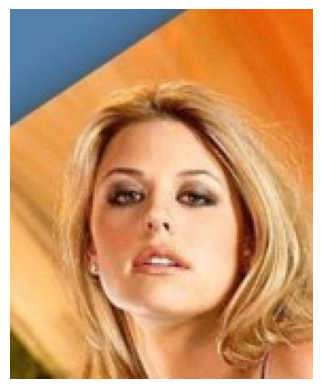

In [54]:
plt.imshow(sample_img.permute(1,2,0))
plt.axis('off');

In [56]:
sample_label = annotations[sample_filename]
sample_label

[0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0]

In [57]:
torch.FloatTensor(np.array(sample_label))

tensor([0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

### Setting transforms and configuring dataloader for training

In [58]:
# transforms
train_transforms = [
    transforms.Resize(int(1.12*img_height), Image.BICUBIC),
    transforms.RandomCrop(img_height),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]

In [59]:
# dataloader
dataloader = DataLoader(
    CelebADataset(
        root, transforms_=train_transforms, mode='train', attributes=selected_attrs
    ),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu
)

In [60]:
len(glob.glob('%s/*.jpg'%root))

202599

In [61]:
# transforms
val_transforms = [
    transforms.Resize((img_height, img_width), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
]

In [62]:
# dataloader
val_dataloader = DataLoader(
    CelebADataset(
        root, transforms_=val_transforms, mode='test', attributes=selected_attrs
    ),
    batch_size=10,
    shuffle=True,
    num_workers=1
)

### Defining Gradient Penalty Function

In [63]:
# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

In [64]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN-GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = Tensor(np.random.random((real_samples.size(0),1,1,1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha*real_samples + ((1-alpha)*fake_samples)).requires_grad_(True) # requires_grad inplace
    d_interpolates, _ = D(interpolates) # adv_info, cls_info = discriminator(interpolated image)
    fake = Tensor(np.ones(d_interpolates.shape))
    # Get gradient w.r.t interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0),-1)
    gradient_penalty = ((gradients.norm(2, dim=1)-1)**2).mean()
    return gradient_penalty

In [ ]:
for i, (imgs, labels) in enumerate(dataloader):
    print(imgs.size())
    break

In [ ]:
temp_real_samples = torch.from_numpy(np.random.randn(16,3,128,128))
temp_fake_samples = torch.from_numpy(np.random.randn(16,3,128,128))
temp_real_samples = temp_real_samples.type(torch.FloatTensor).cuda()
temp_fake_samples = temp_fake_samples.type(torch.FloatTensor).cuda()
print(temp_real_samples.size(), temp_fake_samples.size())

In [ ]:
temp_alpha = torch.FloatTensor(np.random.random((temp_real_samples.size(0),1,1,1))).cuda()
temp_alpha.size()

In [ ]:
temp_interpolates = (temp_alpha*temp_real_samples + (1-temp_alpha)*temp_fake_samples).requires_grad_(True)
temp_interpolates.size()

In [ ]:
temp_d_interpolates, temp_cls = discriminator(temp_interpolates)
print(temp_d_interpolates.size()) # 16 batches and 1 output channel
print(temp_d_interpolates[0]) 
print(temp_cls.size()) # 16 batches and 5 domains
print(temp_cls) # predict `real or fake` probabilities of each domain

In [ ]:
temp_fake = Tensor(np.ones(temp_d_interpolates.shape))
temp_fake.size()

In [ ]:
temp_gradients = autograd.grad(
        outputs=temp_d_interpolates, # size : [16, 1, 2, 2]
        inputs=temp_interpolates, # size : [16, 3, 128, 128]
        grad_outputs=temp_fake, # size : [16, 1, 2, 2]
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
temp_gradients.size()

In [ ]:
temp_gradients = temp_gradients.view(temp_gradients.size(0),-1) # flatten
temp_gradients.size()

In [ ]:
print(temp_gradients.size())
print(temp_gradients.norm(2, dim=1).size()) # Euclidean distance of the Metrix

In [ ]:
gradients_penalty = ((temp_gradients.norm(2, dim=1)-1)**2).mean()
gradients_penalty

### Defining function to get sample images with input label list

In [10]:
#These are for my selected attributes, if one has changed the selected attributes list in the start, he must do changes in this function also.
"""selected_attrs = [
0 '5_o_Clock_Shadow',
1 'Arched_Eyebrows',
2 'Attractive',
3 'Bags_Under_Eyes',
4 'Bald',
5'Bangs',
6 'Big_Lips',
7 'Big_Nose',
8 'Black_Hair',
9 'Blond_Hair',
10 'Blurry',
11 'Brown_Hair',
12 'Bushy_Eyebrows',
13 'Chubby',
14 'Double_Chin',
15 'Eyeglasses'
16    'Male', 
17   'Young'] 
"""
label_changes = [
    ((7, 1), (8, 0), (10, 0)),  # Setting to black hair --> Black_Hair : 1, Blond_Hair : 0, Brown_Hair : 0
    ((7, 0), (8, 1), (10, 0)),  # Set to blonde hair -> Black_Hair : 0, Blond_Hair : 1, Brown_Hair : 0
    ((7, 0), (8, 0), (10, 1)),  # Set to brown hair --> Black_Hair : 0, Blond_Hair : 0, Brown_Hair : 1
    ((16, -1),),  # Flip gender --> if 0 -> -1, elif 1 -> 0
    ((17, -1),),  # Age flip    --> if 0 -> -1, elif 1 -> 0
    
]

In [55]:
def sample_images():
    """Show a generated sample of domain translations"""
    val_imgs, val_labels = next(iter(val_dataloader))
    val_imgs = val_imgs.type(Tensor)
    val_labels = val_labels.type(Tensor)
    img_samples = None
    for i in range(10):
        img, label = val_imgs[i], val_labels[i]
        # Repeat for number of label changes
        imgs = img.repeat(c_dim, 1, 1, 1) # c_dim is number of domains (5)
        labels = label.repeat(c_dim, 1)
        # Make changes to lab els
        for sample_i, changes in enumerate(label_changes):
            for col, val in changes:
                labels[sample_i, col] = 1 - labels[sample_i, col] if val == -1 else val
        # Generate translations
        gen_imgs = generator(imgs, labels)
        # Concatenate images by width
        gen_imgs = torch.cat([x for x in gen_imgs.data], -1)
        img_sample = torch.cat((img.data, gen_imgs), -1)
        # Add as row to generated samples
        img_samples = img_sample if img_samples is None else torch.cat((img_samples, img_sample),-2)
    plt.figure(figsize=(4,8))
    plt.imshow(img_samples.permute(1,2,0).detach().cpu())
    plt.axis('off')
    plt.show()

In [56]:
temp_val_imgs, temp_val_labels = next(iter(val_dataloader))
temp_val_imgs = temp_val_imgs.type(Tensor)
temp_val_labels = temp_val_labels.type(Tensor)

print(temp_val_imgs.size()) # 10 batches(val_dataloader), 3 channels, image size of 128x128
print(temp_val_labels.size()) # 10 batches and 5 domains

torch.Size([10, 3, 128, 128])
torch.Size([10, 5])


In [57]:
for i in range(10):
    temp_img, temp_label = temp_val_imgs[i], temp_val_labels[i]
    print('1 image --> ',temp_img.size())
    print('1 label --> ',temp_label.size())
    temp_imgs = temp_img.repeat(c_dim,1,1,1) # repeat(copy) image x 5(number of domain)
    temp_labels = temp_label.repeat(c_dim,1) # repeat(copy) label x 5(number of domain)
    print('5 images -> ',temp_imgs.size()) 
    print('5 labels -> ',temp_labels.size())
    break

1 image -->  torch.Size([3, 128, 128])
1 label -->  torch.Size([5])
5 images ->  torch.Size([5, 3, 128, 128])
5 labels ->  torch.Size([5, 5])


In [58]:
for sample_i, changes in enumerate(label_changes):
    print(sample_i, changes)

0 ((0, 1), (1, 0), (2, 0))
1 ((0, 0), (1, 1), (2, 0))
2 ((0, 0), (1, 0), (2, 1))
3 ((3, -1),)
4 ((4, -1),)


In [59]:
for sample_i, changes in enumerate(label_changes):
    for col, val in changes:
        print('iter :', col)
        print('value :', val)

iter : 0
value : 1
iter : 1
value : 0
iter : 2
value : 0
iter : 0
value : 0
iter : 1
value : 1
iter : 2
value : 0
iter : 0
value : 0
iter : 1
value : 0
iter : 2
value : 1
iter : 3
value : -1
iter : 4
value : -1


In [60]:
temp_labels # original labels

tensor([[0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.]], device='cuda:0')

In [61]:
for sample_i, changes in enumerate(label_changes):
    for col, val in changes:
        temp_labels[sample_i, col] = 1 - temp_labels[sample_i, col] if val == -1 else val

In [62]:
temp_labels # modified labels

tensor([[1., 0., 0., 1., 0.],
        [0., 1., 0., 1., 0.],
        [0., 0., 1., 1., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1.]], device='cuda:0')

In [63]:
copied_temp_imgs = temp_imgs
copied_temp_imgs.size()

torch.Size([5, 3, 128, 128])

In [64]:
copied_temp_imgs_group = torch.cat([x for x in copied_temp_imgs.data],-1)
copied_temp_imgs_group.size()

torch.Size([3, 128, 640])

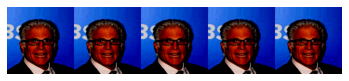

In [65]:
plt.imshow(copied_temp_imgs_group.permute(1,2,0).detach().cpu())
plt.axis('off');

In [66]:
temp_gen_imgs = generator(temp_imgs, temp_labels)

In [67]:
temp_gen_imgs.size()

torch.Size([5, 3, 128, 128])

In [68]:
len([x for x in temp_gen_imgs.data]) # loop of images (5)

5

In [69]:
temp_gen_imgs_group = torch.cat([x for x in temp_gen_imgs.data],-1)
temp_gen_imgs_group.size()

torch.Size([3, 128, 640])

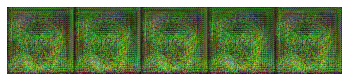

In [70]:
plt.imshow(temp_gen_imgs_group.permute(1,2,0).detach().cpu())
plt.axis('off');

In [71]:
temp_img_sample = torch.cat((temp_img.data, temp_gen_imgs_group),-1)
temp_img_sample.size()

torch.Size([3, 128, 768])

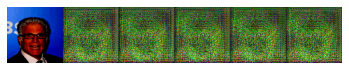

In [72]:
plt.imshow(temp_img_sample.permute(1,2,0).detach().cpu())
plt.axis('off');

In [73]:
temp_img_samples = torch.cat((temp_img_sample, temp_img_sample), -2)
temp_img_samples.size()

torch.Size([3, 256, 768])

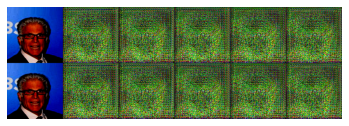

In [74]:
plt.imshow(temp_img_samples.permute(1,2,0).detach().cpu())
plt.axis('off');

### Training

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

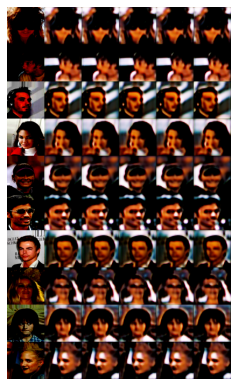

[Epoch 6/100] [Batch 63/63] [D adv: -9.913464, aux: 6.928902] [G loss: 3.019627, adv: -10.473454, aux: 10.177441, cycle: 0.331564]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

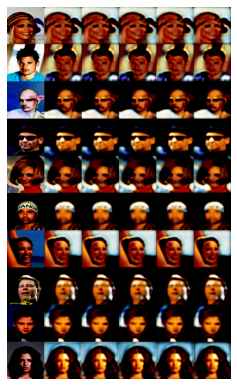

[Epoch 11/100] [Batch 63/63] [D adv: -4.717455, aux: 2.361791] [G loss: 0.403163, adv: -7.698762, aux: 4.737161, cycle: 0.336476]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

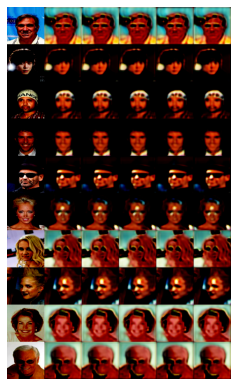

[Epoch 16/100] [Batch 63/63] [D adv: -4.582284, aux: 1.909849] [G loss: 11.505607, adv: 1.816395, aux: 6.748098, cycle: 0.294111]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

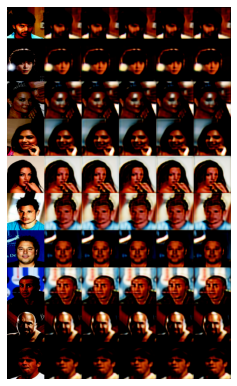

[Epoch 21/100] [Batch 63/63] [D adv: -5.900716, aux: 2.697145] [G loss: 9.247131, adv: 0.261560, aux: 5.829986, cycle: 0.315559]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

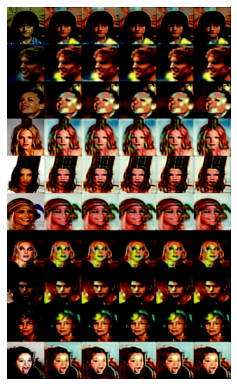

[Epoch 26/100] [Batch 63/63] [D adv: -2.212955, aux: 2.221767] [G loss: 6.635705, adv: -2.685173, aux: 6.834125, cycle: 0.248675]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

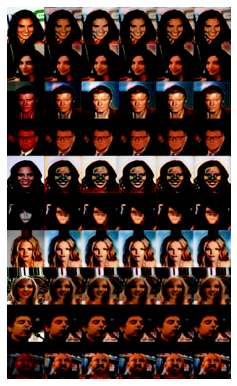

[Epoch 31/100] [Batch 63/63] [D adv: -3.742040, aux: 2.943970] [G loss: 3.855762, adv: -4.289145, aux: 5.941872, cycle: 0.220304]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

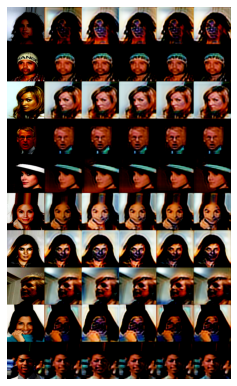

[Epoch 36/100] [Batch 63/63] [D adv: -3.248950, aux: 2.370858] [G loss: 4.124560, adv: -1.575375, aux: 3.375152, cycle: 0.232478]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

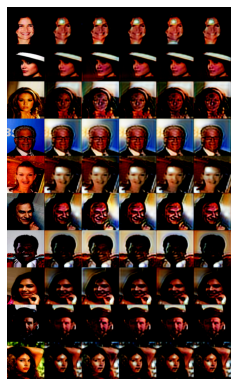

[Epoch 41/100] [Batch 63/63] [D adv: -3.289965, aux: 1.825739] [G loss: 1.855486, adv: -3.655970, aux: 3.308355, cycle: 0.220310]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

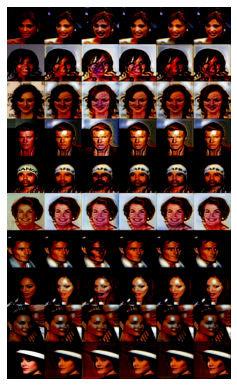

[Epoch 46/100] [Batch 63/63] [D adv: -2.843597, aux: 1.823146] [G loss: -0.831632, adv: -10.055624, aux: 6.988343, cycle: 0.223565]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

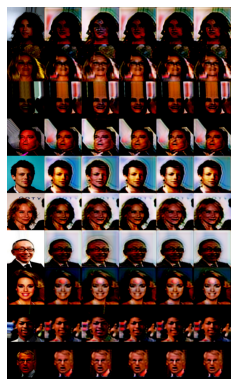

[Epoch 51/100] [Batch 63/63] [D adv: -2.510811, aux: 0.919580] [G loss: 3.773382, adv: -2.977889, aux: 4.561361, cycle: 0.218991]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

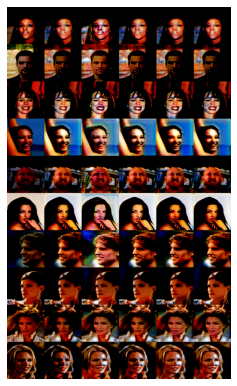

[Epoch 56/100] [Batch 63/63] [D adv: -3.316262, aux: 1.033720] [G loss: 4.555009, adv: -2.457799, aux: 4.873777, cycle: 0.213903]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

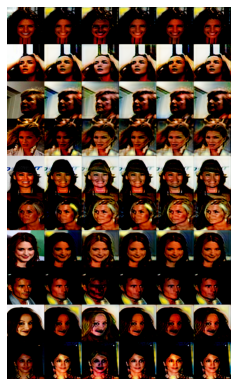

[Epoch 61/100] [Batch 63/63] [D adv: -1.815773, aux: 1.763231] [G loss: 6.611034, adv: -1.410217, aux: 5.556447, cycle: 0.246481]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

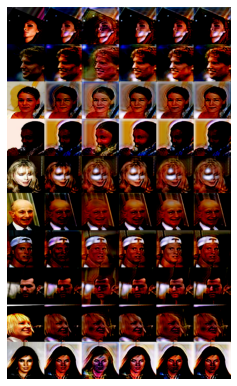

[Epoch 66/100] [Batch 63/63] [D adv: -1.351047, aux: 1.790712] [G loss: 7.647900, adv: -1.562016, aux: 6.814987, cycle: 0.239493]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

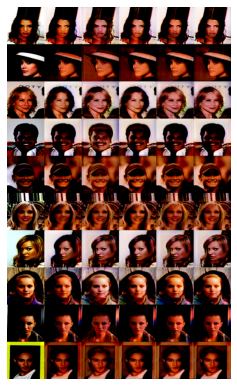

[Epoch 71/100] [Batch 63/63] [D adv: -3.389620, aux: 1.632699] [G loss: 4.015767, adv: -3.269773, aux: 5.020695, cycle: 0.226484]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

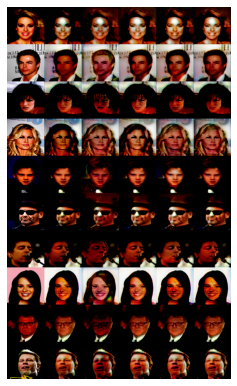

[Epoch 76/100] [Batch 63/63] [D adv: -3.464364, aux: 1.400018] [G loss: 0.138436, adv: -5.435597, aux: 3.597137, cycle: 0.197690]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

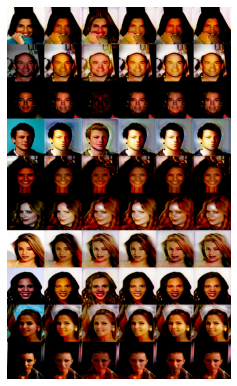

[Epoch 81/100] [Batch 63/63] [D adv: -4.647843, aux: 1.537487] [G loss: 6.847534, adv: 0.147516, aux: 4.704746, cycle: 0.199527]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

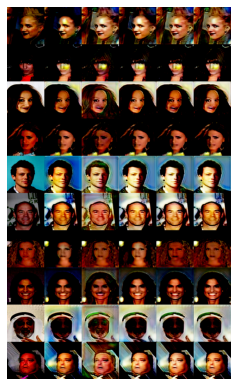

[Epoch 86/100] [Batch 63/63] [D adv: -1.727224, aux: 1.483976] [G loss: 0.819369, adv: -4.994314, aux: 3.657052, cycle: 0.215663]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

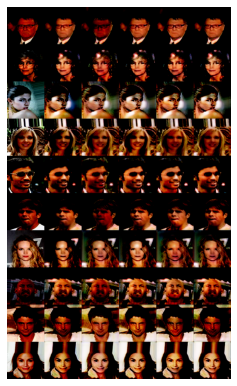

[Epoch 91/100] [Batch 63/63] [D adv: -2.132347, aux: 1.438593] [G loss: 3.601621, adv: -5.859277, aux: 7.431997, cycle: 0.202890]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

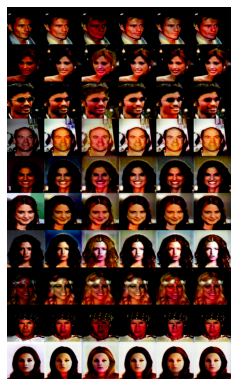

[Epoch 96/100] [Batch 63/63] [D adv: -3.232460, aux: 1.081155] [G loss: 4.754783, adv: -2.165881, aux: 4.665544, cycle: 0.225512]


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

In [76]:
import warnings
warnings.filterwarnings(action='ignore')

for epoch in range(epoch, n_epochs):
    for i, (imgs, labels) in enumerate(tqdm(dataloader)):
        # Model inputs
        imgs = imgs.type(Tensor)
        labels = labels.type(Tensor)
        
        # Sample labels as generator inputs
        sampled_c = Tensor(np.random.randint(0, 2, (imgs.size(0), c_dim)))
        # Generate fake batch of images
        fake_imgs = generator(imgs, sampled_c)
        
# Training Discriminator
        optimizer_D.zero_grad()
        # Real images
        real_validity, pred_cls = discriminator(imgs)
        # Fake images
        fake_validity, _ = discriminator(fake_imgs.detach())
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, imgs.data, fake_imgs.data)
        # Adversarial loss
        loss_D_adv = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp*gradient_penalty
        # Classification loss
        loss_D_cls = criterion_cls(pred_cls, labels)
        # Total loss
        loss_D = loss_D_adv + lambda_cls*loss_D_cls
        
        loss_D.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        
        # Every n_critic times update generator
        if i % n_critic == 0: # n_critic : 5

        # Training Generator
            # Translate and reconstruct image
            gen_imgs = generator(imgs, sampled_c)
            recov_imgs = generator(gen_imgs, labels)
            # Discriminator evaluates translated image
            fake_validity, pred_cls = discriminator(gen_imgs)
            # Adversarial loss
            loss_G_adv = -torch.mean(fake_validity)
            # Classification loss
            loss_G_cls = criterion_cls(pred_cls, sampled_c)
            # Reconstruction loss
            loss_G_rec = criterion_cycle(recov_imgs, imgs)
            # Total loss
            loss_G = loss_G_adv + lambda_cls*loss_G_cls + lambda_rec*loss_G_rec
            
            loss_G.backward()
            optimizer_G.step()
            
    # Show Progress
    if epoch%5 == 0:
        sample_images()
        print("[Epoch %d/%d] [Batch %d/%d] [D adv: %f, aux: %f] [G loss: %f, adv: %f, aux: %f, cycle: %f]"
            % (
                epoch+1, n_epochs,                     # Epoch
                i+1,len(dataloader),                   # Batch
                loss_D_adv.item(),loss_D_cls.item(),   # D loss
                loss_G.item(),loss_G_adv.item(),       # G loss (total, adv)
                loss_G_cls.item(),loss_G_rec.item(),   # G loss (cls, cycle)
            ))



In [77]:
# 16x5 array that contains 0 or 1
print(np.random.randint(0,2,(16,5)))
print('--------------')
print(np.random.randint(0,2,(16,5)).shape)

[[1 0 1 0 0]
 [1 1 0 1 1]
 [1 1 0 0 1]
 [1 1 1 1 1]
 [0 0 1 1 1]
 [0 0 0 1 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [1 0 0 1 1]
 [0 0 0 1 0]
 [1 0 0 0 1]
 [1 0 1 1 0]
 [1 1 1 0 0]
 [0 1 1 0 1]
 [1 0 1 1 1]
 [1 1 1 1 0]]
--------------
(16, 5)
